In [3]:
import pandas as pd
import numpy as np
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize as wtoken
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

import tensorflow as tf
from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import (Activation, Dropout, Dense, Embedding, Flatten, GlobalMaxPooling1D)
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os, string, gc
from tqdm import tqdm
import tldextract as tld


from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
%timeit
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.0.0
Num GPUs Available:  1


In [5]:
def test_tf_gpu():
    tf.debugging.set_log_device_placement(True)
    # Create some tensors
    a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
    b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
    c = tf.matmul(a, b)
    print(c)

In [6]:
train = pd.read_csv('../kaggle/input/google-quest-challenge/train.csv')
test = pd.read_csv('../kaggle/input/google-quest-challenge/test.csv')
samsub = pd.read_csv('../kaggle/input/google-quest-challenge/sample_submission.csv')

In [7]:
train.isnull().values.any()

False

In [8]:
test.isnull().values.any()

False

# Processing domains/urls and convert it to categorical feature, e.g. topic, class, etc..

In [9]:
def ext_subdomains(column):
    """
    intent: extracts subdomains from urls by using tldextract lib
    accepts: a dataframe column/pandas series of urls.
    returns: a list of extracted subdomains.
    """
    subdomains = []
    for c in column:
        subdomains.append(tld.extract(c).subdomain)
    return subdomains

In [10]:
train['topic'] = ext_subdomains(train.url)

In [11]:
test['topic'] = ext_subdomains(test.url)

In [12]:
targets = list(samsub.columns)
targets.pop(0)

'qa_id'

In [13]:
Y = train[targets]

In [14]:
features = ['question_title', 'question_body', 'answer', 'topic', 'category' ]

In [15]:
features_txt = ['question_title', 'question_body', 'answer']

In [16]:
train = train[features]

In [17]:
test = test[features]

In [18]:
train.shape

(6079, 5)

In [19]:
test.shape

(476, 5)

In [20]:
X = train.append(test)

## Label Encoding

In [21]:
# Label Encoding
for c in tqdm( ['topic','category']):
    enc = LabelEncoder()
    enc.fit(X[c])
    X[c] = enc.transform(X[c])

100%|██████████| 2/2 [00:00<00:00, 320.53it/s]


In [22]:
# Convert all chars to lower

for f in tqdm(['question_title', 'question_body', 'answer']):
    X[f] = X[f].str.lower()

100%|██████████| 3/3 [00:00<00:00, 113.82it/s]


## Tokenization with NLTK

In [23]:
from nltk.tokenize import word_tokenize

tokenized_answer=[]

for doc in tqdm(X.answer):
    tokenized_answer.append(word_tokenize(doc))


100%|██████████| 6555/6555 [00:05<00:00, 1151.10it/s]


In [24]:
tokenized_question_body=[]
for doc in tqdm(X.question_body):
    tokenized_question_body.append(word_tokenize(doc))

100%|██████████| 6555/6555 [00:05<00:00, 1195.18it/s]


In [25]:
tokenized_question_title=[]
for doc in tqdm(X.question_title):
    tokenized_question_title.append(word_tokenize(doc))

100%|██████████| 6555/6555 [00:00<00:00, 11297.84it/s]


In [26]:
def remove_non_english(text):
    result = []
    
    for words in tqdm(text):
        result.append([x.replace(re.sub(r'[aA-zZ]',r'',x), '') for x in words])
    return result

In [27]:
def remove_nonalpha(text):
    
    result = []
    
    for w in tqdm(text):
        
        result.append([x for x in w if x.isalpha() and x.isascii()])
    
    return result

In [28]:
def remove_char(text, c=''):
    result = []
    for w in tqdm(text):
        result.append([x for x in w if x !=c])
    return result

In [29]:
def remove_long_words(pd_series):
    # expects a pandas dataframe column/seires 
    # removes any word by its length range( 4-12 chars)
    # returns a list of strings
    result = []
    result = tqdm(pd_series.str.findall('\w{4,12}').str.join(' '))
    return result

In [30]:
def remove_words(text, min_length = 4, max_length = 12):
    result = []
    for w in tqdm(text):
        result.append([x for x in w if len(x) in range(min_length, max_length)])
    return result

In [31]:
tokenized_answer= remove_nonalpha(tokenized_answer)

X['answer'] = remove_char(tokenized_answer)

X['answer'] = remove_words(X['answer'])

100%|██████████| 6555/6555 [00:00<00:00, 31755.47it/s]


In [32]:
tokenized_question_body= remove_nonalpha(tokenized_question_body)

X['question_body'] = remove_char(tokenized_question_body)

X['question_body'] = remove_words(X['question_body'])

100%|██████████| 6555/6555 [00:00<00:00, 19902.29it/s]


In [33]:
tokenized_question_title= remove_nonalpha(tokenized_question_title)

X['question_title'] = remove_char(tokenized_question_title)

X['question_title'] = remove_words(X['question_title'])

100%|██████████| 6555/6555 [00:00<00:00, 324988.03it/s]


In [34]:
del tokenized_answer, tokenized_question_body, tokenized_question_title
gc.collect()

22

## Removing stopwords

In [35]:
stopwords = stopwords.words('english')
for f in tqdm(['question_title', 'question_body', 'answer']):
    X[f] = X[f].apply(lambda x: [word for word in x if word not in stopwords])

100%|██████████| 3/3 [00:01<00:00,  1.96it/s]


## Stemming

In [36]:
lemmatizer = WordNetLemmatizer() 

for f in tqdm(['question_title', 'question_body', 'answer']):
     X[f] = X[f].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


In [37]:
# Stemming using NLTK SnowballStemmer (aka Porter2)

#stemming = nltk.stem.snowball.SnowballStemmer("english", ignore_stopwords=True)

#for f in tqdm(['question_title', 'question_body', 'answer']):
    #X[f] = X[f].apply(lambda x: [stemming.stem(word) for word in x])

## Frequency Distribution

In [38]:

def frequency_distr(text):
    
    freq_dist = {}
    
    allWords = []
    
    for wordList in text:
        allWords += wordList

    # Frequency dist.
    freq_dist = nltk.FreqDist(allWords)

    # Take only the words
    word_features_qt = list(freq_dist.keys())#[:5000]

    print('Number of words: {}'.format(len(freq_dist)))
    print('Most common words: {}'.format(freq_dist.most_common(10)))
    return freq_dist

In [39]:
fdist_qt = {}
fdist_qb = {}
fdist_an = {}

fdist_qt = frequency_distr(X['question_title'])

fdist_qb = frequency_distr(X['question_body'])

fdist_an = frequency_distr(X['answer'])

    

Number of words: 5535
Most common words: [('using', 252), ('file', 194), ('server', 127), ('make', 122), ('window', 122), ('page', 121), ('change', 113), ('user', 111), ('value', 111), ('without', 109)]
Number of words: 16438
Most common words: [('would', 2850), ('like', 2573), ('using', 1993), ('want', 1806), ('file', 1746), ('question', 1583), ('know', 1541), ('time', 1534), ('work', 1498), ('code', 1390)]
Number of words: 23763
Most common words: [('would', 2640), ('like', 2090), ('need', 1946), ('also', 1832), ('using', 1591), ('time', 1585), ('make', 1569), ('want', 1445), ('could', 1403), ('file', 1402)]


In [40]:
#fdist_qt= {k: v for k, v in sorted(fdist_qt.items(), key=lambda item: item[1])}

In [41]:
X['question_title'].values[500]

['reading', 'file', 'network', 'location']

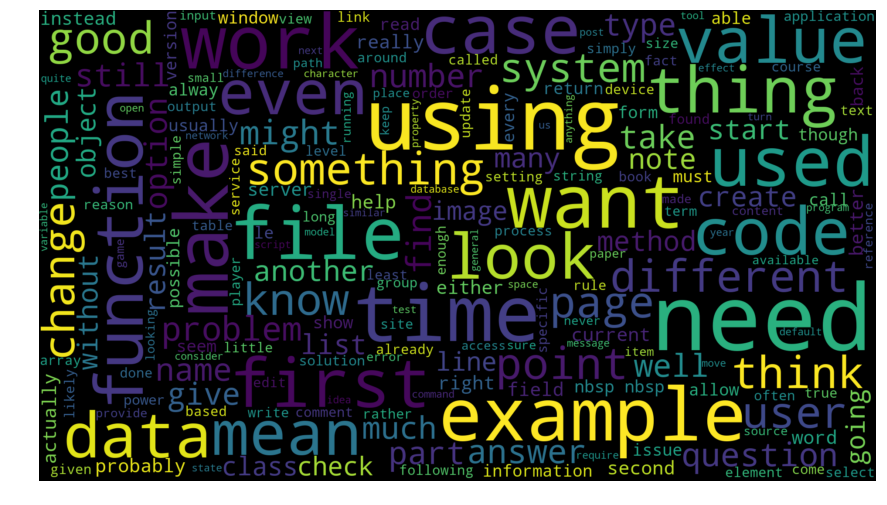

In [42]:
all_words=''
for w in X.answer:
    all_words+= ' '.join([text for text in w])
    
wordcloud = WordCloud(width=1920, height=1080, random_state=21, max_font_size=210).generate(all_words)

plt.figure(figsize=(15, 10))

fig1 = plt.gcf()

plt.imshow(wordcloud, interpolation="bilinear")

plt.axis('off')

plt.show()

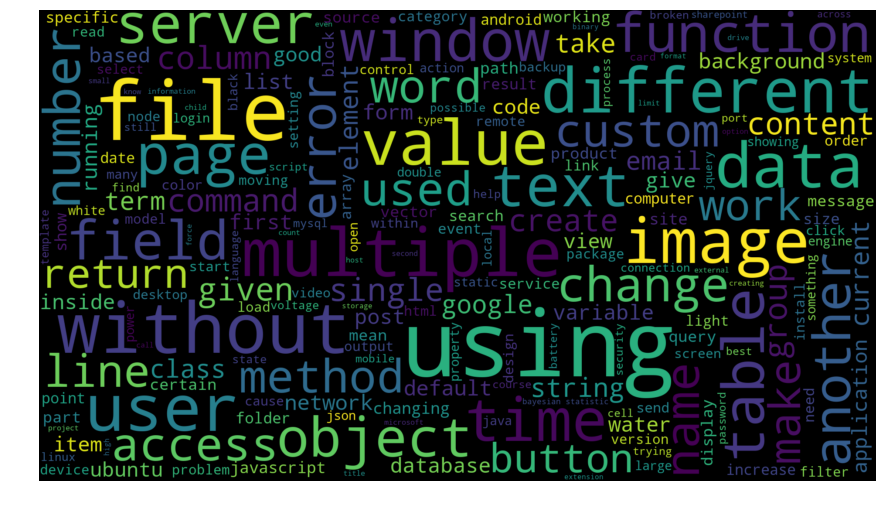

In [43]:
all_words=''
for w in X.question_title:
    all_words+= ' '.join([text for text in w])
    
wordcloud = WordCloud(width=1920, height=1080, random_state=21, max_font_size=210).generate(all_words)

plt.figure(figsize=(15, 10))

fig1 = plt.gcf()

plt.imshow(wordcloud, interpolation="bilinear")

plt.axis('off')

plt.show()

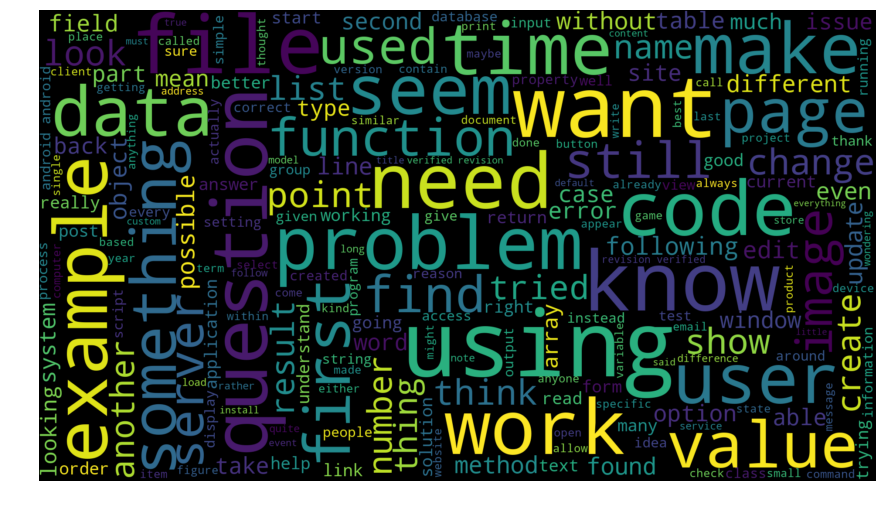

In [44]:
all_words=''
for w in X.question_body:
    all_words+= ' '.join([text for text in w])
    
wordcloud = WordCloud(width=1920, height=1080, random_state=21, max_font_size=210).generate(all_words)

plt.figure(figsize=(15, 10))

fig1 = plt.gcf()

plt.imshow(wordcloud, interpolation="bilinear")

plt.axis('off')

plt.show()

In [45]:
X.head()

,question_title,question_body,answer,topic,category
0,"[losing, using, extension, tube, instead, macr...","[playing, around, macro, photography, read, re...","[extension, tube, skinny, losing, using, tube,...",39,1
1,"[distinction, city, downtown, commercial, dist...","[trying, understand, kind, place, spam, value,...","[might, helpful, look, definition, spam, zone,...",44,0
2,"[maximum, protusion, length, component, pin]","[working, component, side, board, side, board,...","[even, need, groove, make, several, product, u...",19,2
3,"[affidavit, used, beit]","[affidavit, understand, basically, signed, doc...","[sending, affidavit, dispute, rashi, rabbeinu,...",27,0
4,"[make, binary, image, photoshop]","[trying, make, binary, image, want, look, imag...","[check, image, trace, adobe, illustrator, like...",26,1


In [46]:
#https://www.kaggle.com/alvations/word2vec-embedding-using-gensim-and-nltk

In [47]:
#https://streamhacker.com/2014/12/29/word2vec-nltk/

In [48]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

In [49]:
for f in features_txt:
    X[f] = X[f].apply(embed)
    X[f] = [w.numpy() for w in X[f]]

In [50]:
import webbrowser
webbrowser.open('https://www.youtube.com/watch?v=ns5YEEGkvzg')

True

In [56]:
train = X.iloc[:train.shape[0], :train.shape[1]]

In [57]:
train.shape

(6079, 5)

In [58]:
test = X.iloc[:test.shape[0], :test.shape[1]]

In [59]:
test.shape

(476, 5)

In [60]:
Y.shape

(6079, 30)

In [63]:
train.to_csv('../kaggle/input/google-quest-challenge/train_ready.csv', index = False)

In [64]:
test.to_csv('../kaggle/input/google-quest-challenge/test_ready.csv', index = False)

In [65]:
Y.to_csv('../kaggle/input/google-quest-challenge/targets.csv', index = False)